In [12]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import lightgbm as lgb 

from sklearn.metrics import accuracy_score, roc_auc_score 

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)


In [9]:
url = 'https://raw.githubusercontent.com/sitsawek/dataset/main/healcare_stroke_data/healthcare-dataset-stroke-data.csv'

In [184]:
df = pd.read_csv(url)

In [189]:
def get_prep_data(df):
    df['ever_married'] = (
        df['ever_married'].replace('Yes', True).replace('No', False)
    )
    df['gender'] = df['gender'].astype('category')
    df['smoking_status'] = df['smoking_status'].astype('category')
    df['Residence_type'] = df['Residence_type'].astype('category')
    df['work_type'] = df['work_type'].astype('category')
    df['doctor'] = np.random.randint(0, 8, size=len(df))
    holdout_ids = df.sample(n=500, random_state=529).index

    train = (
        df.loc[~df.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values('doctor')
        .reset_index(drop=True)
    )

    holdout = (
        df.loc[df.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values('doctor')
        .reset_index(drop=True)
    )
    return train, holdout

In [190]:
train, holdout = get_prep_data(df)

In [191]:
def get_X_y(train):
    FEATURES = [
        'gender',
        'age',
        'hypertension',
        'heart_disease',
        'ever_married',
        'work_type',
        'Residence_type',
        'avg_glucose_level',
        'bmi',
        'smoking_status',
    ]

    GROUPS = 'doctor'

    TARGET = 'stroke'

    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    return X, y, groups


In [192]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,72784,Female,52.0,0,0,True,Private,Rural,118.46,61.6,smokes,0,0
1,13380,Male,14.0,0,0,False,children,Urban,111.27,23.2,Unknown,0,0
2,30692,Male,73.0,0,0,True,Private,Rural,82.13,28.5,never smoked,0,0
3,22147,Female,74.0,0,0,True,Private,Urban,203.01,25.4,never smoked,0,0
4,14444,Female,37.0,0,0,False,Self-employed,Urban,90.71,45.8,Unknown,0,0


In [183]:
X, y, groups = get_X_y(train)

In [33]:
clf = lgb.LGBMClassifier(n_estimators=100)
clf.fit(X, y)

LGBMClassifier()

In [37]:
# Predict
pred = clf.predict(X)
pred_proba = clf.predict_proba(X)[:,1]

In [43]:
acc_score = accuracy_score(y, pred)
auc_score = roc_auc_score(y, pred_proba)
print(f'Accuracy : {acc_score:0.4f} AUC : {auc_score:0.4f}')

Accuracy : 0.9911 AUC : 0.9997


In [46]:
X_holdouts, y_holdouts, groups_holdouts = get_X_y(holdout)
pred_holdouts = clf.predict(X_holdouts)
pred_proba_holdouts = clf.predict_proba(X_holdouts)[:, 1]
acc_score_holdouts = accuracy_score(y_holdouts, pred_holdouts)
auc_score_holdouts = roc_auc_score(y_holdouts, pred_proba_holdouts)
print(f'Accuracy : {acc_score_holdouts:0.4f} AUC : {auc_score_holdouts:0.4f}')


Accuracy : 0.9380 AUC : 0.7802


In [56]:
# Baseline predicting by zero
accuracy_score(y, np.zeros_like(y)), roc_auc_score(y, np.zeros_like(y))

(0.9516268980477224, 0.5)

# Train Test Split

In [76]:
X, y, groups = get_X_y(train)
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1)
clf = lgb.LGBMClassifier(n_estimators=100, max_depth=3)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_val)
pred_proba = clf.predict_proba(X_val)[:,1]
acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_proba)
print(f'Accuracy : {acc_score:0.4f} AUC : {auc_score:0.4f}')
# This look overfit!

Accuracy : 0.9588 AUC : 0.8574


## Cross Validation

In [85]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

### KFold

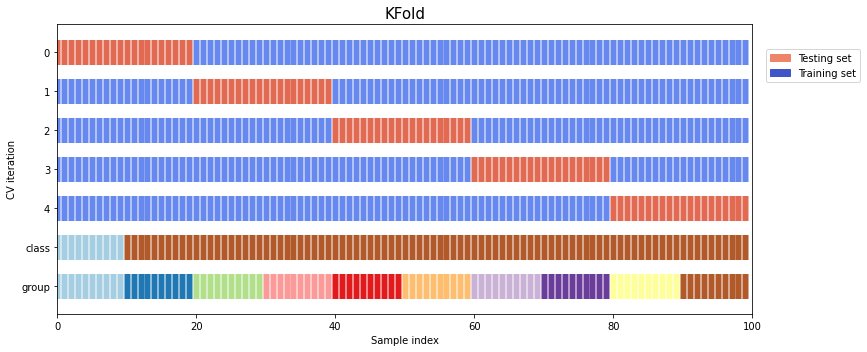

In [87]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

In [110]:
pd.DataFrame(y_).rename({0:'class'}, axis=1).groupby('class').size()

class
0    10
1    90
dtype: int64

### Stratified KFold

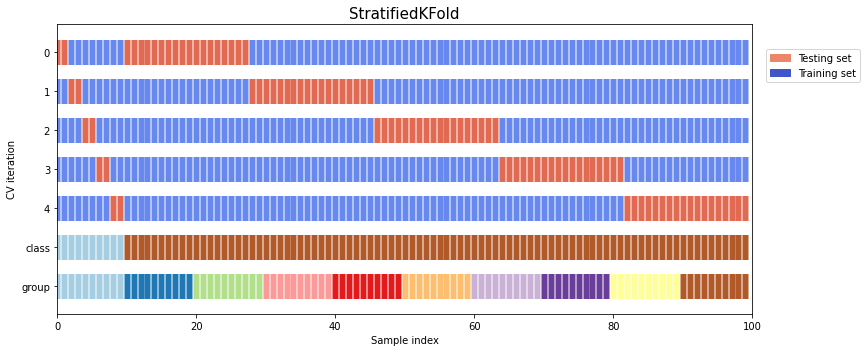

In [111]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

- The differenct between KFold and StratifiedKFold is StratifiedKFold try to auto balance target variable in in each fold.

- In case of imbalance dataset

### GroupKFold

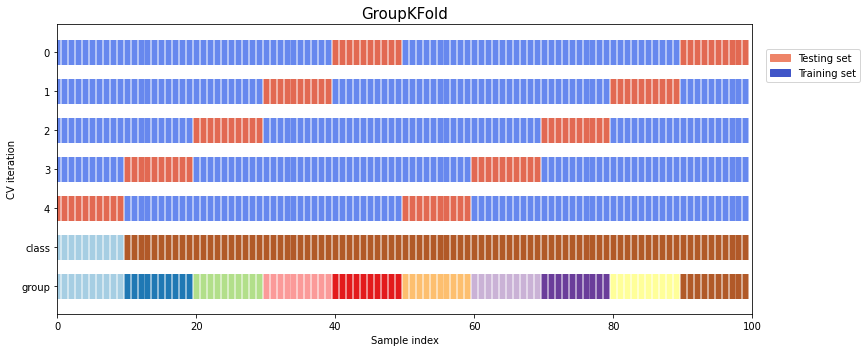

In [113]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

- For make sure no data leaked between group.

### Stratified Group KFold

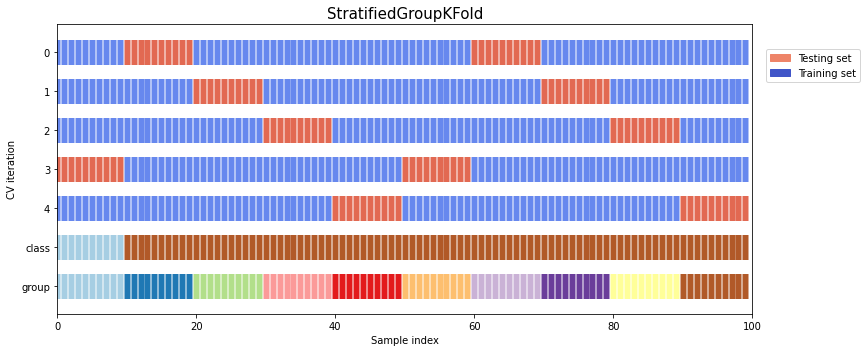

In [121]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

- Trying to preserve the percentage of samples in each class as much as possible while preserving the non-overlapping groups.

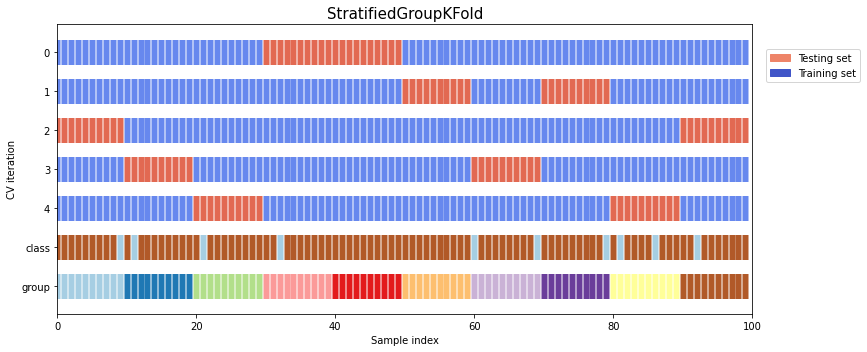

In [124]:
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

In [141]:
pd.concat([pd.DataFrame(groups_).rename({0:'groups'}, axis=1),
pd.DataFrame(y_).rename({0:'class'}, axis=1)], axis=1).groupby(['groups', 'class']).size().reset_index().rename({0:'count'}, axis=1)

,groups,class,count
0,0,0,1
1,0,1,9
2,1,0,1
3,1,1,9
4,2,0,1
5,2,1,9
6,3,0,1
7,3,1,9
8,4,1,10
9,5,1,10


### Time Series Split

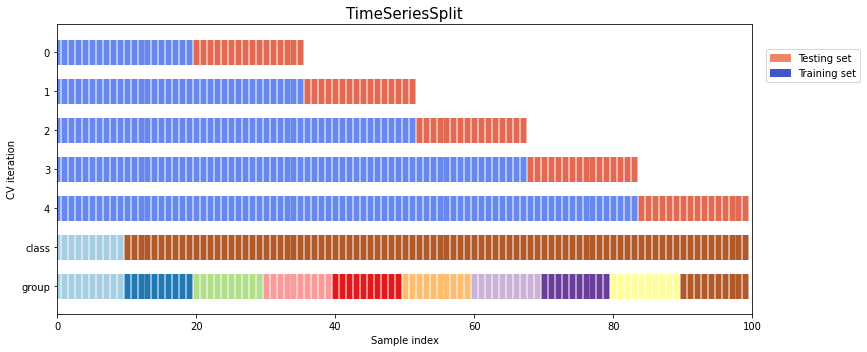

In [123]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(TimeSeriesSplit, X_, y_, groups_)

- For make sure that none of the infomation about the future is fed into your model to give it observation about something
    it shouldn't have seen at that moment in time.

- time series machine learning should cover this.

### Example

In [193]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)
X, y, groups = get_X_y(train)
fold = 0
aucs = []
for train_idx, valid_idx in sgk.split(X, y, groups):
    X_tr = X.loc[train_idx]
    X_val = X.loc[valid_idx]

    y_tr = y.loc[train_idx]
    y_val = y.loc[valid_idx]

    #model
    clf = lgb.LGBMClassifier(n_estimators=100, max_depth=3)
    clf.fit(X_tr, y_tr)

    pred = clf.predict(X_val)
    pred_proba = clf.predict_proba(X_val)[:, 1]

    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_proba)
    fold += 1
    print(f'Fold {fold}')
    print(f'Accuracy : {auc_score:0.4f} AUC : {auc_score:0.4f}')
    aucs.append(auc_score)

Fold 1
Accuracy : 0.8273 AUC : 0.8273
Fold 2
Accuracy : 0.8816 AUC : 0.8816
Fold 3
Accuracy : 0.8448 AUC : 0.8448
Fold 4
Accuracy : 0.8282 AUC : 0.8282
Fold 5
Accuracy : 0.8554 AUC : 0.8554


In [195]:
np.mean(aucs)

0.8474431873310861